# Classification

In [1]:
# in this chapter I will be using MNIST dataset. It has 70,000 small images of digits handwritten by high school student and employees. 
# Each image is labelled 

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1) # fetch mnist dataset
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
# let's look at the data
X, y = mnist["data"], mnist["target"]

In [4]:
print("X shape", X.shape)
print("y shape", y.shape)

X shape (70000, 784)
y shape (70000,)


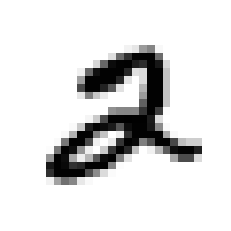

In [12]:
# there are 70000 images and each image has 784 features. This is because each image of 28 by 28 pixels is flattend into single dimension.
# The image is represented by one channel hence one pixel has value ranging from 0 to 255.
# we can display it using Matplotlibs imshow() function

import matplotlib.pyplot as plt
import matplotlib as mpl

some_digit = X.iloc[5].values
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [20]:
# let's look what the label is
print(y[5])
print(type(y[5])) # the label is string. let's convert it to number

2
<class 'str'>


In [22]:
# import numpy
import numpy as np
y = y.astype(np.uint8) # convert string value to unsigned integer of 8 bit

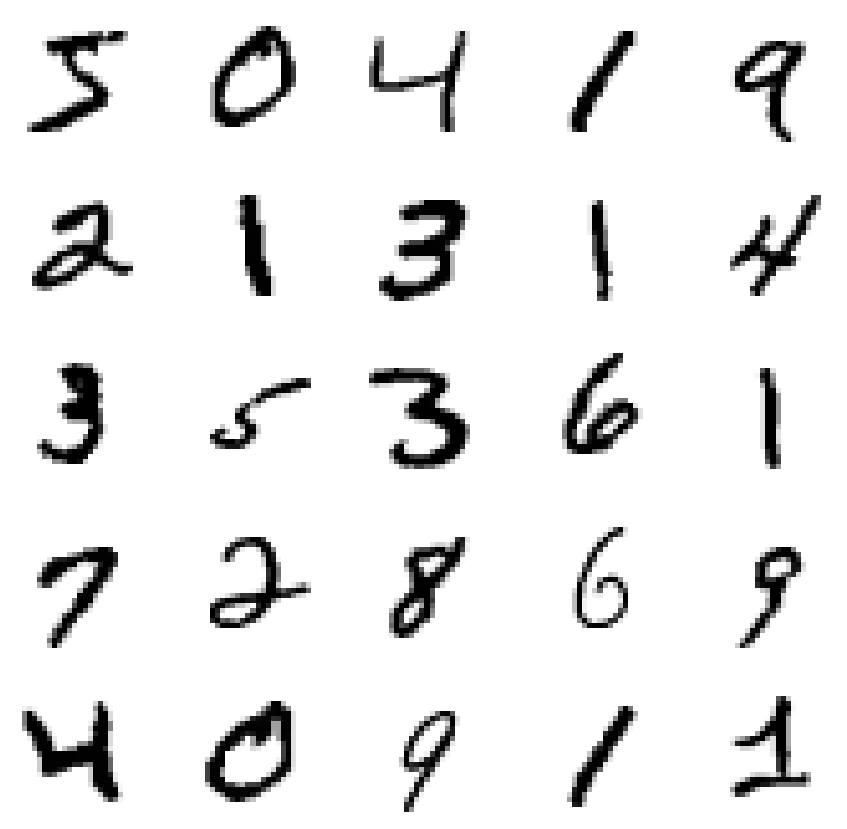

In [34]:
# show 25 image of mnist data set
plt.figure(figsize=(15,15))
for i in range(25):    
    plt.subplot(5,5,i+1)    
    plt.axis("off")
    plt.grid(False)    
    plt.imshow(X.iloc[i].values.reshape(28,28), cmap=plt.cm.binary)    
    plt.xlabel(y.iloc[i])

plt.show()

In [35]:
# split train test 
X = X.values
y = y.values
X_train, X_test, y_train, y_test = X[:60000], X[60000:],y[:60000], y[60000:]

## Binary Classification

In [36]:
# training a binary classifier
# let's simply the problem and train to identify only one digit. This 5-detector
y_train_5 = (y_train==5) # true for all 5 and false for all other digits
y_test_5 = (y_test==5)

In [37]:
# let's pick a classifier and train it
# a good place is to start with a stochastic gradient descennt

from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=12)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=12)

In [39]:
# now we can use it to detect image of the number 5
sgd_clf.predict([some_digit])

array([False])

#### Performance Measure 

In [40]:
# implementing cross validation

In [42]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True,random_state=12)

for train_index, test_index in skfolds.split(X_train,y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred==y_test_fold)
    print(n_correct/len(y_pred)) # accuracy in eacy K Fold

0.91315
0.9605
0.92475


In [43]:
# let's use cross_val_score() function to evaluate our SGD Classifier
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train,y_train_5, cv=3, scoring='accuracy')

array([0.9659 , 0.96095, 0.9645 ])

In [44]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self,X,y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X),1), dtype=bool)

In [45]:
never_5_clf = Never5Classifier()

In [46]:
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

In [47]:
# that's right it has over 90% accuracy. This is simply because only about 10% of the images are 5s, so if we guess always image is not 5.
# we have 90% of the time

#### Confusion matrix

In [49]:
from sklearn.model_selection import cross_val_predict
y_train_predict = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
# just like cross_val_score(), cross_val_predict() performs K-fold cross-validation, but instead of returning the evaluation scores, 
# it returns the repdictions made on each test fold. The menas you get a clean prediction of each instance of the training set.

In [52]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_predict)

array([[53730,   849],
       [ 1324,  4097]])

In [53]:
# each row in confusion matrix represents actual class
# each column in confusion matrix represents predicted class
y_train_predictions = y_train_5 # pretend we reached perfections
confusion_matrix(y_train_5, y_train_predictions)

array([[54579,     0],
       [    0,  5421]])

precision = TP / (TP + FP)

recall / true positive rate = TP / (TP + FN) --> The ratio of positive instances that are correctly detected by the classifier

![](../images/02-confusion-matrix.png)

In [55]:
from sklearn.metrics import precision_score, recall_score
print("Precision", precision_score(y_train_5, y_train_predict))
print("Recall", recall_score(y_train_5, y_train_predict))

Precision 0.8283461382935705
Recall 0.7557646190739716


In [56]:
# it is convenient to combine precision and recall into a single metric called F1 score. 
# the F1 score in particular is the harmonic mean of precision and recall
# the harmonic mean gives much more weight to low values. 
# as a result, we get F1 score high, only when both recall and precision is high

In [57]:
# f1 = 2 * precision * recall / (precision + recall)
from sklearn.metrics import f1_score
print("F1 Score", f1_score(y_train_5, y_train_predict))

F1 Score 0.7903925918780746


![Precision Recall Tradeoff](../images/03-precision-recall-tradeoff.png)


In [58]:
# raising a threshold decreases recall

In [59]:
# scikit-learn does not let us to set the threshold directly. we can use decision score and then create our own predict function

In [64]:
y_scores = sgd_clf.decision_function([some_digit])
print("Decision Function scores", y_scores)
threshold = 0 # this is default for SGD Classifier
y_some_digit_pred = (y_scores > threshold)


Decision Function scores [-8103.84560071]


In [68]:
# how do you decide which treshold to use ?
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5,cv=3, method='decision_function')

In [69]:
# with these scores we use precision_recall_curve to compute precision recall for all possible thresholds
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_train_5, y_scores)

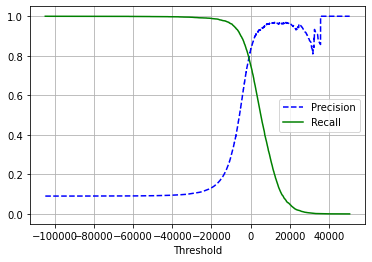

In [77]:
# finally use matplotlib to plot precision and recall as function of the threshold values
def plot_precision_recall_vs_thresholds(precision,recall, thresholds):
    plt.plot(thresholds, precision[:-1], "b--", label="Precision")
    plt.plot(thresholds, recall[:-1], "g-", label="Recall")
    plt.grid("on")
    plt.xlabel("Threshold")
    plt.legend()

plot_precision_recall_vs_thresholds(precision, recall, thresholds)
plt.show()

In [81]:
# suppose we decide to aim for 90% precision.
threshold_90_precision = thresholds[np.argmax(precision >= 0.90)]
print("threshold for 90% precision", threshold_90_precision)

threshold for 90% precision 2369.135160955669


In [82]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [83]:
# let's check these predictions' precision and recall
print("precision score", precision_score(y_train_5, y_train_pred_90))
print("recall score", recall_score(y_train_5, y_train_pred_90))

precision score 0.9001791656002047
recall score 0.6487732890610588


#### The ROC Curve

In [84]:
# receiver operating characteristics is another common tool used with binary classfication
# similary to precision vs recall curver
# plot of true posittive rate vs true negative rate
# true positive rate is the recall
# false positive rate is the ratio of negative instance that are incorrectly classified as positive 

In [85]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [87]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--') # dashed diagnol
    plt.grid("on")
    plt.xlabel("false positive rate")
    plt.ylabel("true positive rate")
    plt.show()

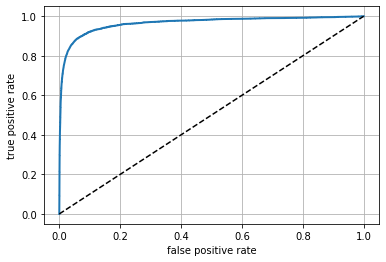

In [88]:
plot_roc_curve(fpr, tpr)
plt.show()

In [89]:
# once again there is trade off between recall and false positive rate
# the dotted line represents purely random classifier
# a good classifier stays as far away from this dotted line possible

In [91]:
# one way to compare classifier is the area under the curve
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9647311126740128

In [92]:
# let's train a random forest classifier and compare its roc curve and roc_auc_score

In [93]:
from sklearn.ensemble import RandomForestClassifier

In [95]:
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [96]:
y_probas_forest

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       ...,
       [0.02, 0.98],
       [0.92, 0.08],
       [0.94, 0.06]])

In [98]:
y_scores_forest = y_probas_forest[:,1] # score = probability of first class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

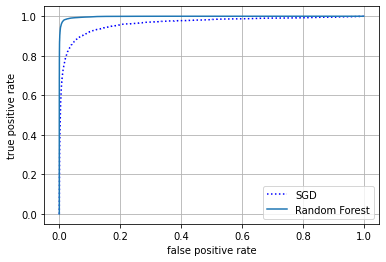

In [102]:
plt.plot(fpr, tpr, "b:", label="SGD")
plt.plot(fpr_forest, tpr_forest, label="Random Forest")
plt.legend(loc="lower right")
plt.ylabel("true positive rate")
plt.xlabel("false positive rate")
plt.grid()
plt.show()

In [103]:
print("roc auc score", roc_auc_score(y_train_5, y_scores_forest))

roc auc score 0.9983436731328145


## Multiclass Classification

multiclass classification can distinguish between more than two classes

some algorithms are capable of handling multiclass classification(SGD, Random Forest, Naive). others(SVM, logistic) are strictly binary classifier. 

In [106]:
from sklearn.svm import SVC

svc_model = SVC() # initiatiate SVC Classifier
svc_model.fit(X_train, y_train) # fit the model


# predict the model
svc_model.predict([some_digit])

array([2], dtype=uint8)

In [107]:
# under the hood SVC uses One Vs One strategy. It trained 45 binary classifiers and got their decision scores

In [109]:
some_digit_scores = svc_model.decision_function([some_digit])
print("some digit scores", some_digit_scores)

some digit scores [[ 2.7442516  -0.30125634  9.31399134  7.26965016  3.75753908  3.74771902
   0.71155138  2.76650678  8.2765048   6.21840456]]


In [110]:
# the score is indeed highest for label 2

In [113]:
np.argmax(some_digit_scores) # argmax gives the index of the highest value of the list

2

In [115]:
svc_model.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [116]:
# we can force scikit-learn to use either one vs one or one vs rest strategy during multiclass clasification

In [117]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC()) # the SVC will use one vs rest strategy
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([2], dtype=uint8)

In [118]:
len(ovr_clf.estimators_)

10

In [119]:
# training and SGD Classifier
sgd_clf.fit(X_train, y_train)

SGDClassifier(random_state=12)

In [120]:
sgd_clf.predict([some_digit])

array([2], dtype=uint8)

In [121]:
# the decision function returns one value per class
sgd_clf.decision_function([some_digit])

array([[ -8364.25363366, -27493.50795184,   5605.95301262,
         -9228.04252052, -19945.42485507,  -6922.14935167,
        -17675.08145648, -16694.13461057,  -6949.89795695,
         -6807.14394891]])

In [122]:
# we can use cross_val_score to evaluate SGD accuarcy
cv_accuracies = cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')
print("Cross validationn accuracies", cv_accuracies)

Cross validationn accuracies [0.87075 0.8922  0.87925]


In [125]:
# Simple scaling the data will increase the accuracy
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cv_accuracies = cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')
print("Cross validationn accuracies", cv_accuracies)

Cross validationn accuracies [0.9004  0.89625 0.89835]


#### Error Analysis

In [126]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

NameError: name 'y_train_scaled' is not defined

In [129]:
conf_matrix = confusion_matrix(y_train, y_train_pred)
conf_matrix

array([[5581,    0,   21,    7,    9,   49,   36,    6,  213,    1],
       [   1, 6401,   37,   26,    4,   44,    4,    8,  205,   12],
       [  27,   26, 5228,   92,   70,   26,   71,   36,  375,    7],
       [  23,   17,  112, 5240,    2,  208,   27,   41,  390,   71],
       [  10,   14,   45,   10, 5208,   12,   35,   26,  319,  163],
       [  28,   15,   31,  167,   54, 4451,   73,   16,  526,   60],
       [  29,   15,   44,    3,   42,   99, 5554,    4,  127,    1],
       [  20,    8,   51,   29,   49,   12,    3, 5701,  185,  207],
       [  18,   65,   45,   91,    3,  130,   25,   10, 5423,   41],
       [  23,   18,   29,   67,  116,   36,    1,  177,  369, 5113]])

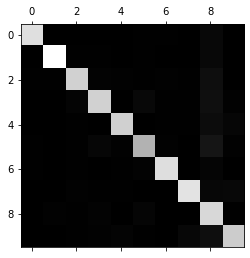

In [130]:
plt.matshow(conf_matrix, cmap=plt.cm.gray)
plt.show()

In [132]:
# let's focus on the plot on the error
row_sums = conf_matrix.sum(axis=1, keepdims=True)
norm_conf_matrix = conf_matrix/row_sums

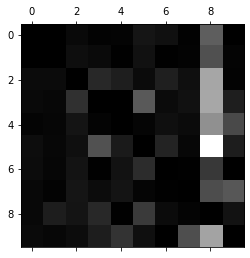

In [136]:
# fill the diagnols with zeros to keep only the errors and plot the result
np.fill_diagonal(norm_conf_matrix, 0)
plt.matshow(norm_conf_matrix, cmap=plt.cm.gray)
plt.show()

#### Multilabel Classification

In [151]:
# classification system that outputs multiple binary tags is called multilabel classification.
# Example: Classifier trained to recognize three people A, B, C. If the image has A and C then output should be [1, 0, 1]

In [154]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [155]:
knn_clf.predict([some_digit])

array([[False, False]])

In [157]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)

In [158]:
f1_score(y_multilabel, y_train_knn_pred, average='macro') # we can also set average='weighted' based on the project

0.976410265560605

#### Multioutput Classification

In [127]:
# it simply means each label can be multiclass

In [165]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = y_test 

In [169]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [170]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[1]])

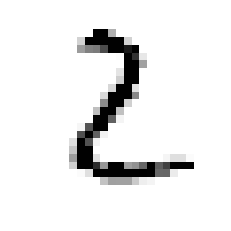

In [171]:
plot_digit(clean_digit)
plt.show()